# MCMC with `EFTEMU` and `zeus`.

In this notebook we show an example MCMC run with the `EFTEMU` and the ensemble slice sampling `Python` code; `zeus` ([Karamanis, Beutler, Peacock (2021)](https://arxiv.org/abs/2105.03468)).

The analysis oresented in Donald-McCann, Koyama, Beutler (in-prep) involves many MCMC runs and it is not very convenient to always run these interactively in a notebook. We provide a script, `runMCMCwEFTEMU.py`, that allows an MCMC to be run with a single command from the terminal. This notebook serves to explain what is happening in that script, we recomend using the script for further MCMC runs.

This notebook is split into the following sections:
1. Mock data
2. Defining the log-probability
3. MAP estimate
4. MCMC with `zeus`

In [1]:
import matryoshka.emulator as MatEmu
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize
from scipy.stats import norm
import zeus
from scipy.interpolate import interp1d
import corner

As with most of the other notebooks in this repo we start by specifying the repo location.

In [2]:
path_to_repo = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/"

## 1. Mock data

For this example we load the CMASS-like mock at $z=0.61$ with a volume $V_s=(3700\ \mathrm{Mpc}/h)^3$. This mock data was produced in `make_mocks_cov_and_poles.ipynb`.

In [3]:
P0_true = np.load(path_to_repo+"data/P18/z0.61/poles/P0_P18--z-0.61_optiresum-False.npy")[1]
P2_true = np.load(path_to_repo+"data/P18/z0.61/poles/P2_P18--z-0.61_optiresum-False.npy")[1]
klin = np.load(path_to_repo+"data/P18/z0.61/poles/P2_P18--z-0.61_optiresum-False.npy")[0]
cov = np.load(path_to_repo+"data/P18/z0.61/covs/cov_P18--z-0.61_Vs-3700.npy")

We define again our true cosmology and bias parameters.

In [4]:
cosmo_true = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665])
bs_CMASS = np.array([2.22, 1.2, 0.1, 0.0, 0.4, -7.7, 0., 0., 0., -3.7])
fb_true = cosmo_true[1]/(cosmo_true[0]+cosmo_true[1])
ng = 3e-4

Now we load our emulators that we trained with the script `trainEFTEMUcomponents.py` that is included with the `matryoshka` package.

In [5]:
P0_emu = MatEmu.EFT(multipole=0, redshift=0.61)
P2_emu = MatEmu.EFT(multipole=2, redshift=0.61)

2022-02-09 13:33:34.712603: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Before doing any kind of fitting we first see how well our emulators predict the true multipoles. To do this we need to convert $c_2$ and $c_4$ to $b_2$ and $b_4$.

In [6]:
def c_to_b(c2, c4):
    return np.array([1/np.sqrt(2)*(c2+c4),1/np.sqrt(2)*(c2-c4)])

bs_CMASS_mod = np.copy(bs_CMASS)
bs_CMASS_mod[[1,3]] = c_to_b(bs_CMASS[1], bs_CMASS[3])

We then make predictions with the `EFTEMU` with the true parameters,

In [7]:
P0_true_pred = P0_emu.emu_predict(cosmo_true.reshape(1,-1), bs_CMASS_mod[:7].reshape(1,-1), 
                                  stochastic=bs_CMASS_mod[7:].reshape(1,-1), ng=ng)[0]
P2_true_pred = P2_emu.emu_predict(cosmo_true.reshape(1,-1), bs_CMASS_mod[:7].reshape(1,-1), 
                                  stochastic=bs_CMASS_mod[7:].reshape(1,-1), ng=ng)[0]

P0_true_pred = interp1d(P0_emu.P11.kbins, P0_true_pred, kind='cubic')(klin)
P2_true_pred = interp1d(P2_emu.P11.kbins, P2_true_pred, kind='cubic')(klin)

and plot the results against the mock multipoles.

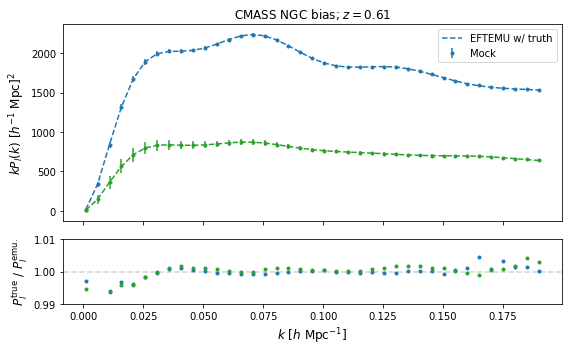

In [8]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,5), gridspec_kw={'height_ratios': [3, 1]})

# Top panel
ax[0].errorbar(klin, klin*P0_true,
               yerr=np.sqrt(cov.diagonal()[:len(klin)])*klin,
               color="tab:blue", linestyle='none', marker='.', label="Mock")
ax[0].errorbar(klin, klin*P2_true,
               yerr=np.sqrt(cov.diagonal()[len(klin):])*klin,
               color="tab:green", linestyle='none', marker='.')              
ax[0].plot(klin, klin*P0_true_pred, color="tab:blue", linestyle='--', label="EFTEMU w/ truth")
ax[0].plot(klin, klin*P2_true_pred, color="tab:green", linestyle='--')

# Bottom panel
ax[1].axhline(1., color='lightgrey', linestyle='--')
ax[1].plot(klin, P0_true/P0_true_pred, color="tab:blue", linestyle='none', marker='.')
ax[1].plot(klin, P2_true/P2_true_pred, color="tab:green", linestyle='none', marker='.')
ax[1].set_ylim(0.99, 1.01)

# Text
ax[0].set_title(r"CMASS NGC bias; $z=0.61$")
ax[1].set_xlabel(r'$k \ [h \ \mathrm{Mpc}^{-1}]$',fontsize='large')
ax[0].set_ylabel(r'$kP_l(k) \ [h^{-1} \ \mathrm{Mpc}]^2$',fontsize='large')
ax[1].set_ylabel(r'$P_l^\mathrm{true} \ / \ P_l^\mathrm{emu.}$',fontsize='large')

ax[0].legend()
plt.tight_layout()

plt.show()

## 2. Defining the log-probability

To run our MCMC we need to define a function for the probability $P(\theta | P') \propto P(\theta)P(P' | \theta)$, with $P'$ being our mock data $P'=[P_0, P_2]$, and $\theta$ being the cosmlogical and bias parameters. In practice we work with the logarithm of the probability $\ln{P(\theta | P')} \propto \ln{P(\theta)} + \ln{P(P' | \theta)}$.

We start with the log-prior $\ln{P(\theta)}$. Our prior can be thought of as having two parts; the first being the prior on the cosmolgical parameters, and the second being the prior on the bias parameters and counterterms.

The prior on the cosmological parameters is defined by the training samples we used to tain the emulator. We can not expect the emulators to produce good predictions outside of this training space. We this in mind we define the priors on all cosmological parameters to be uniform distributions $\mathcal{U}(a, b)$ with $a$ and $b$ being the maximum and minimum values from the training set.

For the priors on the bias parameters and counterterms we to the priors defined in d'Amico et al. (2019) section 3.5.

$$
\begin{align}
&b_1\sim\mathcal{U}(0, 4),  &c_2\sim\mathcal{U}(-4, 4),\\
&b_3\sim\mathcal{N}(0, 2),  &c_{ct}\sim\mathcal{N}(0, 2),\\
&c_{r,1}\sim\mathcal{N}(0, 8),  &c_{\epsilon,1}\ / \ n_g \sim\mathcal{N}(0, 400),\\
&c_q\sim\mathcal{N}(0, 2).
\end{align}
$$

In [9]:
def log_prior(theta, ng, cosmo_bounds):
    # Oc, Ob, h, As, ns
    cosmo = theta[:,:5]
    # b1, c2, b3, c4, cct, cr1, cr2
    bias = theta[:,5:12]
    # ce1, cmono, cquad
    stoch = theta[:,12:]
    
    # Evaluate uniform prior on cosmo params.
    box_cosmo = np.greater(cosmo[:, 0], cosmo_bounds[0,0]) & np.less(cosmo[:, 0], cosmo_bounds[0,1]) \
        & np.greater(cosmo[:, 1], cosmo_bounds[1,0]) & np.less(cosmo[:, 1], cosmo_bounds[1,1]) \
        & np.greater(cosmo[:, 2], cosmo_bounds[2,0]) & np.less(cosmo[:, 2], cosmo_bounds[2,1])\
        & np.greater(cosmo[:, 3], cosmo_bounds[3,0]) & np.less(cosmo[:, 3], cosmo_bounds[3,1])\
        & np.greater(cosmo[:, 4], cosmo_bounds[4,0]) & np.less(cosmo[:, 4], cosmo_bounds[4,1])
    
    box_bias = np.greater(bias[:, 0], 0.) & np.less(bias[:, 0], 4.) \
        & np.greater(bias[:, 1], -4.) & np.less(bias[:, 1], 4.)
    
    return np.where(box_cosmo, 0, -np.inf)+np.where(box_bias, 0, -np.inf)\
           +norm.logpdf(bias[:,2], loc=0, scale=2)\
           +norm.logpdf(bias[:,3], loc=0, scale=2)\
           +norm.logpdf(bias[:,4], loc=0, scale=2)\
           +norm.logpdf(bias[:,5], loc=0, scale=8)\
           +norm.logpdf(bias[:,6], loc=0, scale=4)\
           +norm.logpdf(stoch[:,0]/ng, loc=0, scale=400)\
           +norm.logpdf(stoch[:,1], loc=0, scale=2)\
           +norm.logpdf(stoch[:,2], loc=0, scale=2)

Next we move onto our log-likelihood. We use a Gaussian likelihood with the from

$$\mathcal{L}(P'|\theta)=-\frac{1}{2}(\tilde{P}-P')\mathbf{C}^{-1}(\tilde{P}-P')^T\ ,$$

with $\tilde{P}$ being the `EFTEMU` predictions, and $\mathbf{C}$ being the mock covariance.

In [10]:
def log_like(theta, kobs, obs, icov, ng):
    # Oc, Ob, h, As, ns
    cosmo = theta[:,:5]
    # b1, c2, b3, c4, cct, cr1, cr2
    bias = theta[:,5:12]
    # ce1, cmono, cquad
    stoch = theta[:,12:]
    
    
    c2 = np.copy(bias[:,1])
    c4 = np.copy(bias[:,3])
    
    bias[:,1] = (c2+c4)/np.sqrt(2)
    bias[:,3] = (c2-c4)/np.sqrt(2)
            
    P0_pred = P0_emu.emu_predict(cosmo, bias, stochastic=stoch, ng=ng)
    P2_pred = P2_emu.emu_predict(cosmo, bias, stochastic=stoch, ng=ng)
        
    preds = np.hstack([interp1d(MatEmu.kbird[:39], P0_pred)(kobs), 
                           interp1d(MatEmu.kbird[:39], P2_pred)(kobs)])
    
    res = preds-obs
    
    return -0.5*np.einsum("nj,ij,in->n", res, icov, res.T)

Now we define a function that combines our log-prior and log-likelihood.

In [11]:
def log_prob(theta, kobs, obs, icov, ng, cosmo_bounds, fb, fixed_vals):
    
    # Convert list to array
    theta = np.vstack(theta)
    
    # Fix parameters
    theta = fix_params(theta, fixed_vals, fb)
    
    # Evaluate prior
    lp = log_prior(theta, ng, cosmo_bounds)
    
    # Evaluate likelihood
    ll = log_like(theta, kobs, obs, icov, ng)
    
    return ll+lp

The function `fix_params()` that is called in `log_prob()` is defined below. It allows us to easily fix parameters that we do not allow to vary during our MCMC. 

In [12]:
def fix_params(theta, fix_val, fb):
    
    # Define indicies of parameters that vary.
    var_id = np.array([0,2,3,5,6,7,9,10,12,14])
    
    # Define indicies of fixed params.
    fix_id = np.array([4,8,11,13])
    
    fix_theta = np.zeros((theta.shape[0], 15))
    fix_theta[:,var_id] = theta
    fix_theta[:,fix_id] = np.vstack(theta.shape[0]*[fix_val])
    
    # Comput w_b from baryon fraction and w_c
    fix_theta[:,1] = -fb*theta[:,0]/(fb-1)
    
    return fix_theta

It should be noted that all of the functions above have been defined to work with `zeus` and the option `vectorize=True`, allowing us to exploit the efficency of the `EFTEMU` when making predictions on a batch. See the `performance.ipynb` for demonstration of this.

## 3. MAP estimate

When running an MCMC with an ensemble sampler like `zeus` we need to define starting points for the walkers. We will be initalising the walkers as small perturbations from the _maximum a posteriori_ (MAP) estimate. We will use the `minimize()` funtion from `scipy` to compute the MAP estimate by finding the mimimum negative log-probability.

In [13]:
def neg_log_prob(theta, kobs, obs, icov, ng, cosmo_bounds, fb, fixed_vals):
    
    #Reshaping is required as the log_prob function is designed to work on batch.
    #So we reshape into a bacth of N=1.
    theta = np.array(theta).reshape(1, -1)
    
    return -(log_prob(theta, kobs, obs, icov, ng, cosmo_bounds, fb, fixed_vals))

We extract the extremes of the training sapce that will form the priors on the cosmological parameters.

In [14]:
emu_bounds = np.stack([P0_emu.P11.scalers[0].min_val,
                       P0_emu.P11.scalers[0].min_val+P0_emu.P11.scalers[0].diff]).T

We also define the fixed values for $n_s$, $c_4$, $c_{r,2}$, and $c_\mathrm{mono.}$.

In [15]:
fixed_params = np.array([cosmo_true[-1], 0., 0., 0.])

Finding the MAP estimate requires an inital guess. We will use a random perturbation from the truth as this inital guess.

$$
\begin{align}
&\theta_i = \theta_o+10^{-3}X, &X\sim\mathcal{N}(0,1).
\end{align}
$$

In [16]:
# Define the dimensionality of the fit
ndim=10

init_guess = np.concatenate([cosmo_true[[0,2,3]], bs_CMASS[[0,1,2,4,5,7,9]]])\
             +1e-3*np.random.randn(ndim, )

In [17]:
icov = np.linalg.inv(cov)

In [18]:
results = minimize(neg_log_prob, init_guess, method='Nelder-Mead', options={'disp': True, "maxiter": 100000},
                   args=(klin, np.concatenate([P0_true, P2_true]), icov, ng, emu_bounds, fb_true, fixed_params))

Optimization terminated successfully.
         Current function value: 22.298822
         Iterations: 714
         Function evaluations: 1108


We can now produce predictions for multipoles at the MAP estimate, to do this we first need to input the fixed parameter values,

In [19]:
fixed_results = fix_params(results.x.reshape(1,-1), fixed_params, fb_true)[0]
cosmo_MAP = fixed_results[:5]
bs_MAP = fixed_results[5:12]
bs_MAP[[1,3]] = c_to_b(bs_MAP[1], bs_MAP[3])
stoc_MAP = fixed_results[12:]

then we can produce the predicitons,

In [20]:
P0_MAP_pred = P0_emu.emu_predict(cosmo_MAP.reshape(1,-1), bs_MAP.reshape(1,-1), 
                                  stochastic=stoc_MAP.reshape(1,-1), ng=ng)[0]
P2_MAP_pred = P2_emu.emu_predict(cosmo_MAP.reshape(1,-1), bs_MAP.reshape(1,-1), 
                                  stochastic=stoc_MAP.reshape(1,-1), ng=ng)[0]

P0_MAP_pred = interp1d(P0_emu.P11.kbins, P0_MAP_pred, kind='cubic')(klin)
P2_MAP_pred = interp1d(P2_emu.P11.kbins, P2_MAP_pred, kind='cubic')(klin)

and plot them against the mocks.

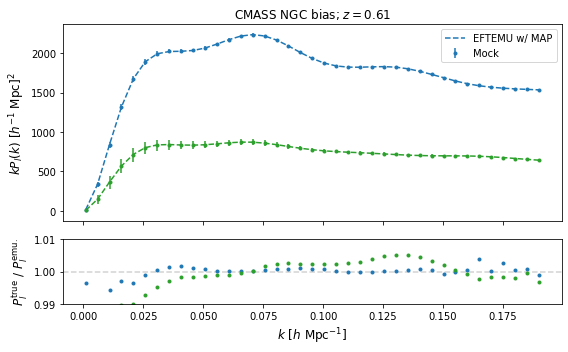

In [21]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,5), gridspec_kw={'height_ratios': [3, 1]})

# Top panel
ax[0].errorbar(klin, klin*P0_true,
               yerr=np.sqrt(cov.diagonal()[:len(klin)])*klin,
               color="tab:blue", linestyle='none', marker='.', label="Mock")
ax[0].errorbar(klin, klin*P2_true,
               yerr=np.sqrt(cov.diagonal()[len(klin):])*klin,
               color="tab:green", linestyle='none', marker='.')              
ax[0].plot(klin, klin*P0_MAP_pred, color="tab:blue", linestyle='--', label="EFTEMU w/ MAP")
ax[0].plot(klin, klin*P2_MAP_pred, color="tab:green", linestyle='--')

# Bottom panel
ax[1].axhline(1., color='lightgrey', linestyle='--')
ax[1].plot(klin, P0_true/P0_MAP_pred, color="tab:blue", linestyle='none', marker='.')
ax[1].plot(klin, P2_true/P2_MAP_pred, color="tab:green", linestyle='none', marker='.')
ax[1].set_ylim(0.99, 1.01)

# Text
ax[0].set_title(r"CMASS NGC bias; $z=0.61$")
ax[1].set_xlabel(r'$k \ [h \ \mathrm{Mpc}^{-1}]$',fontsize='large')
ax[0].set_ylabel(r'$kP_l(k) \ [h^{-1} \ \mathrm{Mpc}]^2$',fontsize='large')
ax[1].set_ylabel(r'$P_l^\mathrm{true} \ / \ P_l^\mathrm{emu.}$',fontsize='large')

ax[0].legend()
plt.tight_layout()

plt.show()

## 4. MCMC with `zeus`

As previously mention `zeus` is an ensemble sampler. So we start this section by defining the positions of the walkers. We will be using the minimum number of walkers required, that being $n_\mathrm{walk.} = 2n_\mathrm{dim.}$. Also as previously mention we will be initalising the walkers as random perturbations from the MAP estimate.

In [22]:
nwalk = 2*ndim
init_pos = results.x+1e-3*np.random.randn(nwalk, ndim)

We next initalise some `zeus.callbacks` that will monitor our chain and determine if it has converged or not. We use two callbacks:
1. `AutocorrelationCallback`; this estimates the integrated autocorreltaion time $\tau$ every `ncheck` iterations and makes sure that the lenght of the chain is at least `nact`$\times\tau$ long, whilst also requiring the estimate of $\tau$ to have converged to within 1%.
2. `MinIterCallback`; this simply makes sure the chain has run for at least `nmin` iterations.

In [23]:
cb0 = zeus.callbacks.AutocorrelationCallback(ncheck=200, dact=0.01, nact=100, discard=0.5)
cb1 = zeus.callbacks.MinIterCallback(nmin=5000)

Now we finally run our MCMC.

In [24]:
sampler = zeus.EnsembleSampler(nwalk, ndim, log_prob, vectorize=True, 
                               args=(klin, np.concatenate([P0_true, P2_true]),
                                     icov, ng, emu_bounds, fb_true, fixed_params), 
                               maxiter=10**5)
sampler.run_mcmc(init_pos, 50000, progress=True, callbacks=[cb0, cb1])

Initialising ensemble of 20 walkers...
Sampling progress :  28%|██████████████▏                                   | 14200/50000 [28:00<1:10:36,  8.45it/s]


We can look at exactly how many likelihood evaluations it took to reach convegrence.

In [25]:
sampler.ncall

1546903

We discard the first $5\tau$ steps, and use the [corner](https://corner.readthedocs.io/en/latest/) package to make a corner plot.

In [33]:
taus = cb0.estimates
flat_chain = sampler.get_chain(discard=5*int(taus[-1]), flat=True)

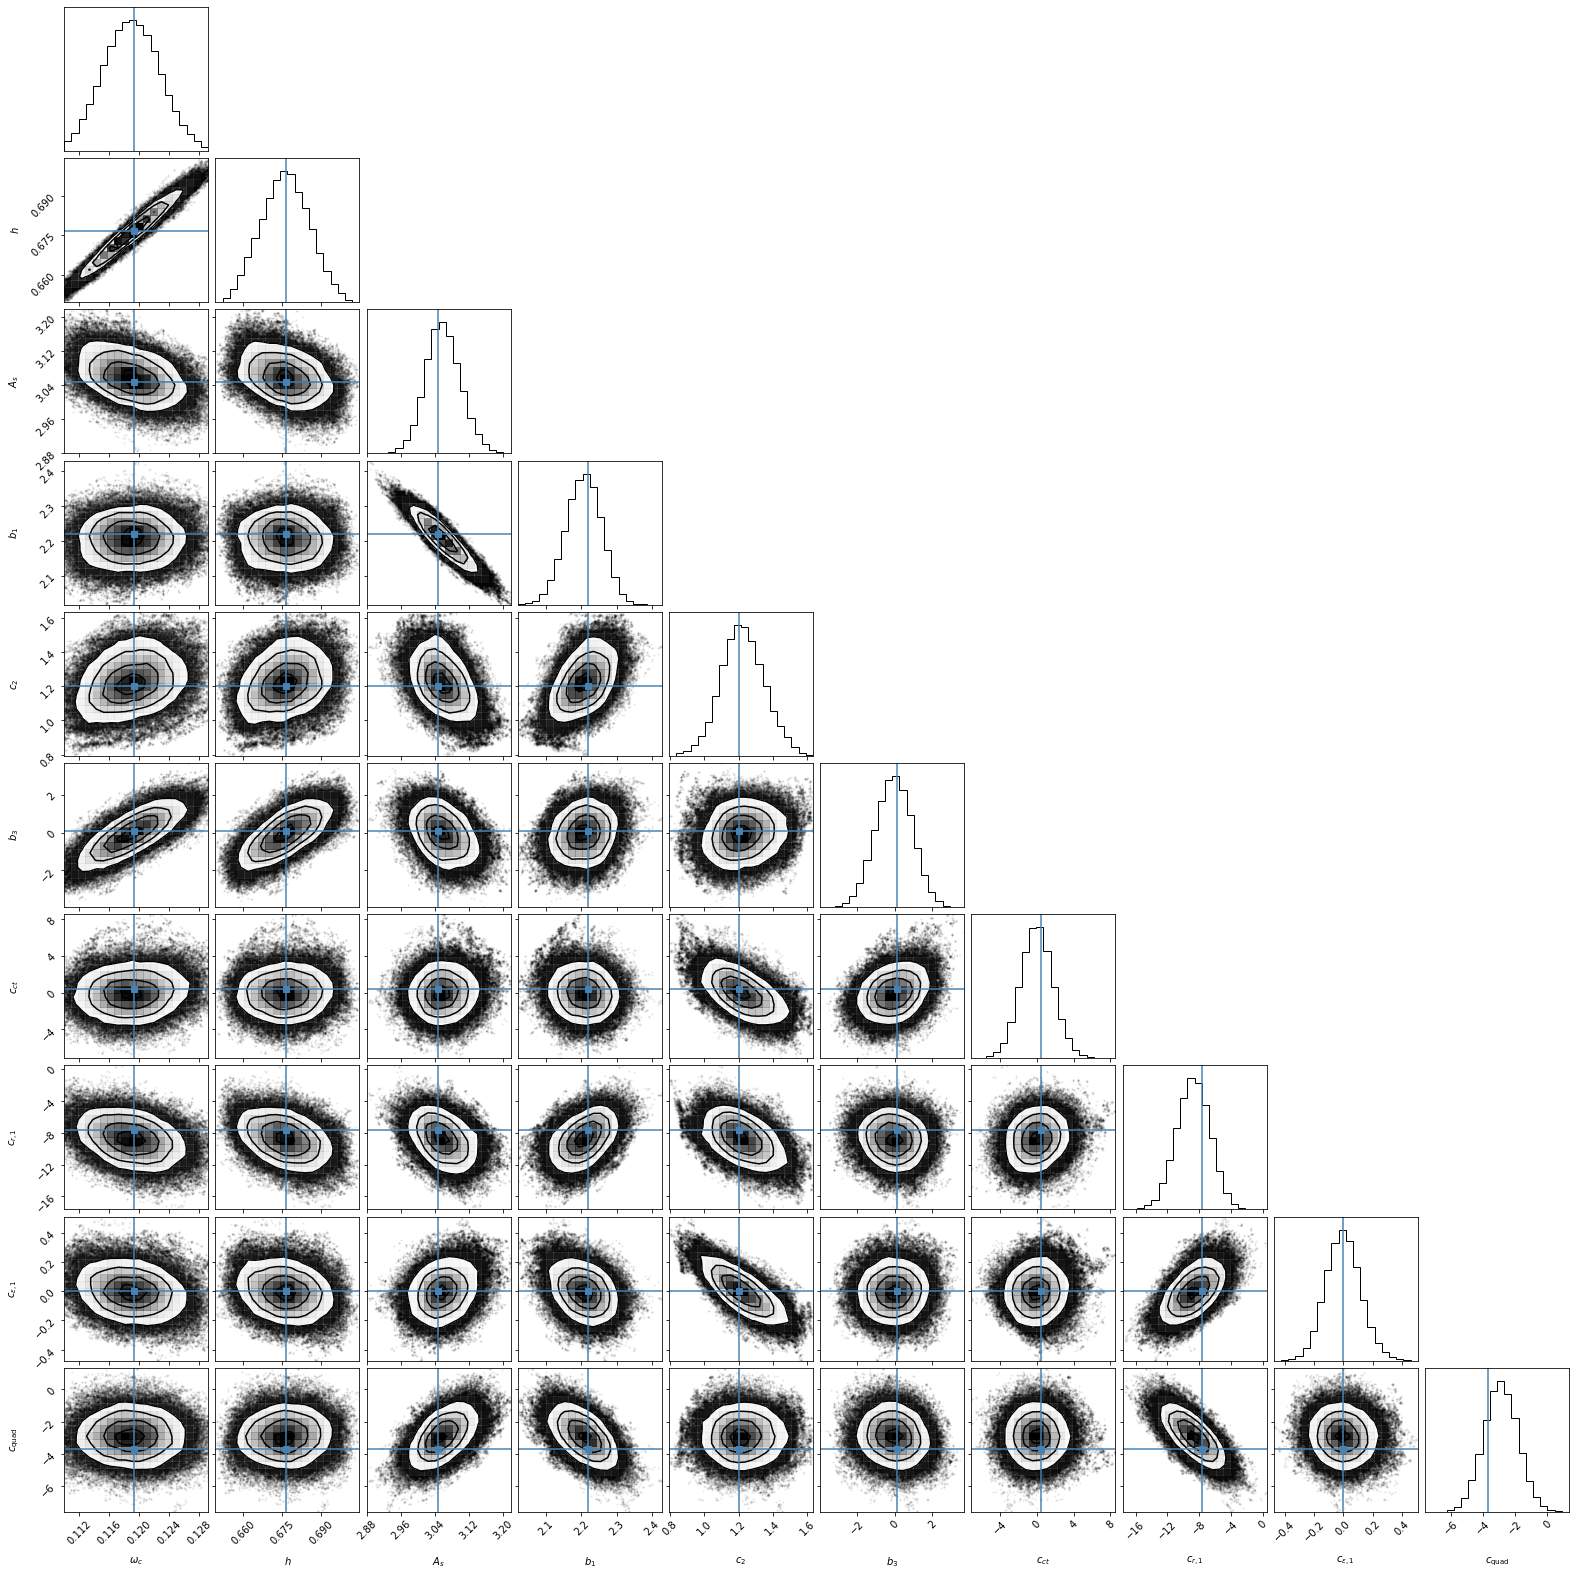

In [34]:
corner.corner(flat_chain, truths=np.concatenate([cosmo_true[[0,2,3]], bs_CMASS[[0,1,2,4,5,7,9]]]), 
              labels=[r'$\omega_c$', r'$h$', r'$A_s$', r'$b_1$', r'$c_2$',
                      r'$b_3$', r'$c_{ct}$', r'$c_{r,1}$', r'$c_{\epsilon,1}$', r'$c_\mathrm{quad}$']);